In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch.nn.functional as F

pd.set_option('display.max_columns', None)

In [26]:
supervector_df_Standard = pd.read_csv(r'D:\Mémoire\Mémoire\Projet\ellipsometry\results\20250511_2255\supervector_maxwell_garnett.csv')
print("Supervector DataFrame :")
supervector_df_Standard.head()

Supervector DataFrame :


psi      delta  wavelength  thickness  vfraction
0  33.891845  11.307751       361.5        0.0      0.005
1  33.215410   6.206663       372.8        0.0      0.005
2  31.951873   3.982396       381.3        0.0      0.005
3  30.713691   2.896009       391.0        0.0      0.005
4  29.759814   2.353519       400.8        0.0      0.005

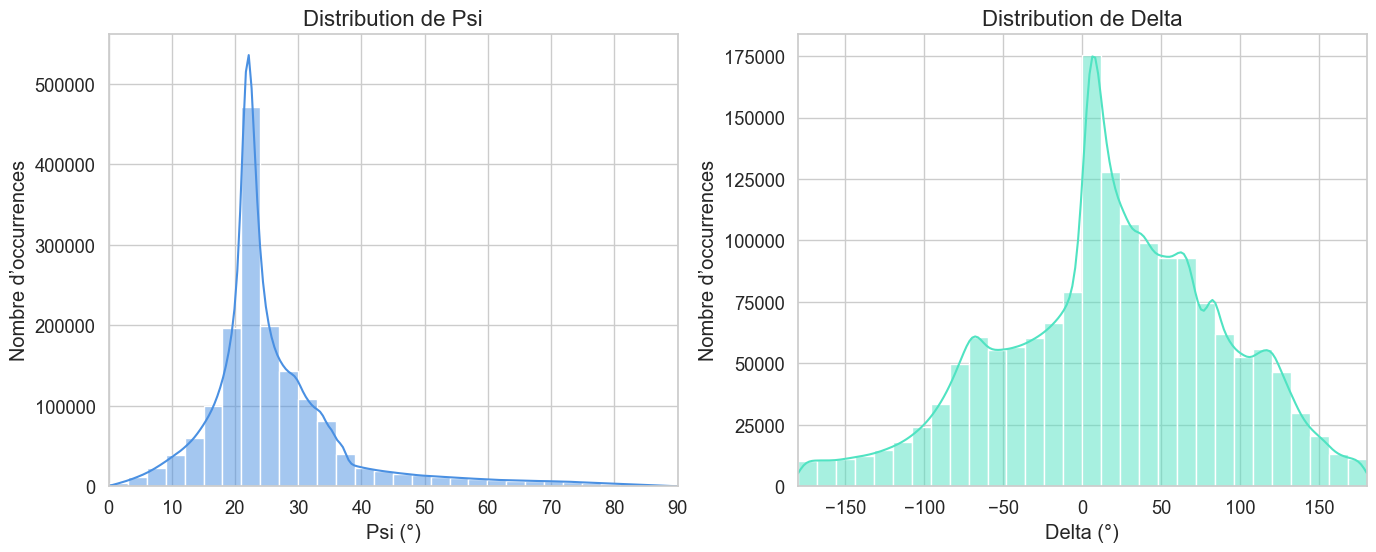

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Style moderne
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["font.family"] = "sans-serif"

# Suppose que supervector_df_Standard est ton DataFrame
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogramme de psi
sns.histplot(supervector_df_Standard["psi"], bins=30, kde=True, ax=axes[0], color="#4A90E2")
axes[0].set_title("Distribution de Psi", fontsize=16)
axes[0].set_xlabel("Psi (°)")
axes[0].set_ylabel("Nombre d’occurrences")
axes[0].set_xlim(0, 90)

# Histogramme de delta
sns.histplot(supervector_df_Standard["delta"], bins=30, kde=True, ax=axes[1], color="#50E3C2")
axes[1].set_title("Distribution de Delta", fontsize=16)
axes[1].set_xlabel("Delta (°)")
axes[1].set_ylabel("Nombre d’occurrences")
axes[1].set_xlim(-180, 180)

# Titre global
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


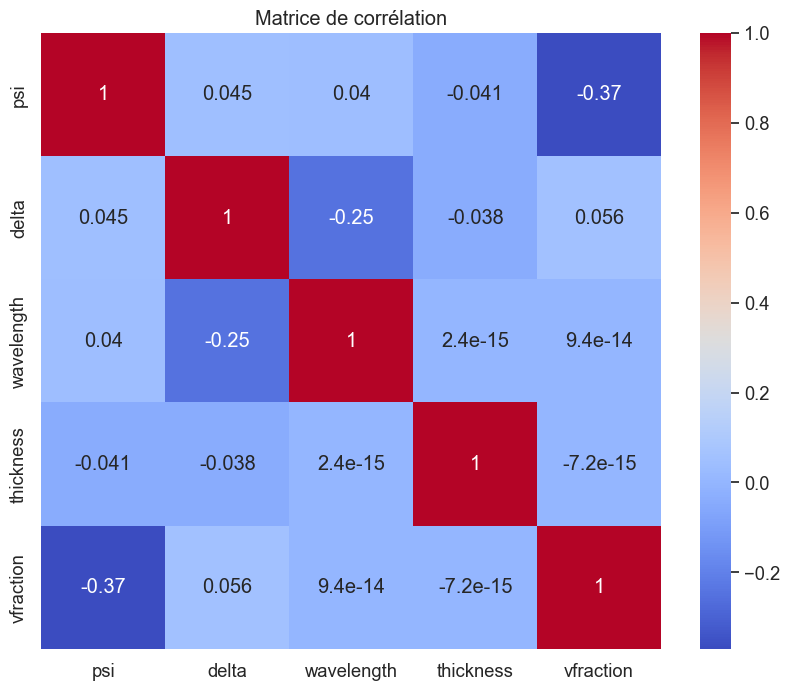

In [28]:
import seaborn as sns

# Matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(supervector_df_Standard.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

In [29]:
def group_and_flatten(df):
    # Déterminer les colonnes de groupement possibles
    possible_group_cols = ['thickness', 'vfraction', 'lambda0', 'gamma', 'amplitude']
    
    # Trouver les colonnes de groupement qui existent dans le dataframe
    group_cols = [col for col in possible_group_cols if col in df.columns]
    
    # Si aucune colonne de groupement n'est trouvée, on peut utiliser une colonne par défaut ou lever une exception
    if not group_cols:
        raise ValueError("Aucune colonne de groupement appropriée trouvée dans le dataframe")
    
    # Effectuer le groupby et le flatten
    grouped = df.groupby(group_cols)[['psi', 'delta']].apply(
        lambda x: x.values.flatten()
    ).reset_index()
    
    # Renommer la colonne résultante
    grouped.columns = list(group_cols) + ['psi_delta_flatten']
    
    return grouped

# Utilisation pour chaque dataset
grouped_standard = group_and_flatten(supervector_df_Standard)
grouped_standard.head()


thickness  vfraction                                  psi_delta_flatten
0        0.0      0.005  [33.891845242290174, 11.307750966698997, 33.21...
1        0.0      0.010  [33.89184524229016, 11.30775096669899, 33.2154...
2        0.0      0.015  [33.89184524229016, 11.307750966699006, 33.215...
3        0.0      0.020  [33.891845242290145, 11.30775096669902, 33.215...
4        0.0      0.025  [33.89184524229017, 11.307750966698997, 33.215...

In [30]:
def prepare_and_split_data(grouped_df, test_size=0.2, random_state=42):
    """
    Prépare les données et les divise en gardant les relations entre les variables cibles
    
    Args:
        grouped_df: DataFrame après group_and_flatten
        test_size: proportion pour le test set
        random_state: seed aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test (y conserve toutes les cibles)
        et la liste des noms des cibles
    """
    # Préparation des features et labels
    X = np.stack(grouped_df['psi_delta_flatten'].values)
    y = grouped_df.drop(columns=['psi_delta_flatten']).values
    label_names = grouped_df.drop(columns=['psi_delta_flatten']).columns.tolist()
    
    # Split en gardant toutes les cibles ensemble
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape} (labels: {label_names})")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test, label_names

In [7]:
#Pour le dataset Standard (tous les paramètres ensemble)
X_train_std, X_test_std, y_train_std, y_test_std, labels_std = prepare_and_split_data(grouped_standard)

X_train shape: (28848, 90)
X_test shape: (7212, 90)
y_train shape: (28848, 2) (labels: ['thickness', 'vfraction'])
y_test shape: (7212, 2)


In [31]:
def augment_data(X, y, noise_level=0.01, num_augmentations=3):
    """
    Augmente les données en ajoutant du bruit gaussien
    
    Args:
        X: Features (psi_delta_flatten)
        y: Labels (paramètres physiques)
        noise_level: Niveau de bruit relatif (écart-type)
        num_augmentations: Nombre de copies augmentées à créer
    
    Returns:
        X_augmented, y_augmented: Données concaténées avec les versions augmentées
    """
    X_augmented = [X]
    y_augmented = [y]
    
    for _ in range(num_augmentations):
        # Bruit sur les features (psi et delta)
        noise_X = np.random.normal(0, noise_level * np.std(X, axis=0), X.shape)
        X_augmented.append(X + noise_X)
        
        # Bruit sur les labels (paramètres physiques)
        noise_y = np.random.normal(0, noise_level * np.std(y, axis=0), y.shape)
        y_augmented.append(y + noise_y)
    
    return np.concatenate(X_augmented), np.concatenate(y_augmented)

In [32]:
# Augmenter les données d'entraînement
X_train_augmented, y_train_augmented = augment_data(X_train_std, y_train_std, noise_level=0.01, num_augmentations=3)

# Afficher les nouvelles dimensions des données
print(f"X_train original shape: {X_train_std.shape}")
print(f"X_train augmented shape: {X_train_augmented.shape}")
print(f"y_train original shape: {y_train_std.shape}")
print(f"y_train augmented shape: {y_train_augmented.shape}")

X_train original shape: (28848, 90)
X_train augmented shape: (115392, 90)
y_train original shape: (28848, 2)
y_train augmented shape: (115392, 2)


In [33]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

def preprocess_and_convert(X_train, X_test, y_train, y_test):
    """
    Applique uniquement une normalisation MinMax aux features et labels.

    Args:
        X_train, X_test: Données d'entrée (features) d'entraînement et de test
        y_train, y_test: Labels (sorties) d'entraînement et de test

    Returns:
        Dictionnaire contenant les tenseurs normalisés et les scalers MinMax
    """
    # Scaler MinMax pour les features
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scaler MinMax pour les labels
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Conversion en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    return {
        'X_train': X_train_tensor,
        'X_test': X_test_tensor,
        'y_train': y_train_tensor,
        'y_test': y_test_tensor,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y
    }

def inverse_transform_y(y_pred_tensor, scaler_y):
    """
    Inverse la normalisation MinMax des prédictions.

    Args:
        y_pred_tensor: Tenseur PyTorch des prédictions.
        scaler_y: Scaler MinMax utilisé pour normaliser y.

    Returns:
        Prédictions dans l'échelle d'origine (numpy array).
    """
    if scaler_y is None:
        return y_pred_tensor.numpy()
    
    y_pred_np = y_pred_tensor.detach().numpy()
    return scaler_y.inverse_transform(y_pred_np)


In [34]:
# Prétraitement et conversion des données
data = preprocess_and_convert(X_train_std, X_test_std, y_train_std, y_test_std)

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class FlexibleNN(nn.Module):
    """
    Réseau neuronal flexible simplifié avec:
    - Nombre de couches configurable
    - Activation paramétrable
    - Initialisation intelligente
    - Pas de BatchNorm
    """
    def __init__(self, input_dim, output_dim, 
                 hidden_dims=[256, 256, 256],
                 activation='leaky_relu',
                 dropout_rate=0.0,
                 apply_sigmoid_to=None,
                 apply_relu_to=None):
        super(FlexibleNN, self).__init__()
        
        self.apply_sigmoid_to = apply_sigmoid_to
        self.apply_relu_to = apply_relu_to
        # Configuration des couches
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Construction dynamique des couches cachées
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(self._get_activation(activation))
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(dims[-1], output_dim)
        
        # Initialisation des poids
        self._init_weights()
    
    def _init_weights(self):
        """Initialisation adaptative des poids"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.1)
    
    def _get_activation(self, name):
        """Retourne la fonction d'activation"""
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
        }.get(name.lower(), nn.LeakyReLU(0.1))
    
    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output(x)
        if self.apply_sigmoid_to is not None:
            x = x.clone()
            for idx in self.apply_sigmoid_to:
                x[:, idx] = torch.sigmoid(x[:, idx])
        if self.apply_relu_to is not None:
            x = x.clone()
            for idx in self.apply_relu_to:
                x[:, idx] = F.relu(x[:, idx])
        return x

In [36]:
# Courbes de loss
def plot_losses(train_loss, test_loss, title):
    plt.style.use('default')
    plt.figure(figsize=(14, 7))

    plt.plot(train_loss, label='Perte Entraînement', color='navy', linewidth=2.5)
    plt.plot(test_loss, label='Perte Test', color='darkorange', linewidth=2.5)

    min_test_loss = min(test_loss)
    min_epoch = test_loss.index(min_test_loss)
    plt.scatter(min_epoch, min_test_loss, color='crimson', s=50, zorder=5,
                label=f'Min Test Loss\n(Epoch {min_epoch}): {min_test_loss:.4f}')

    plt.xlabel('Épochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    n_epochs = max(len(train_loss), len(test_loss))
    plt.xlim(0, n_epochs - 1)
    plt.legend(fontsize=14, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_predictions(model, X_test, y_test, scaler_y, label_names, title):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    if y_pred.shape[1] != y_test.shape[1]:
        print(f"Erreur : dimensions incohérentes ({y_pred.shape[1]} vs {y_test.shape[1]})")
        return

    y_test_orig = inverse_transform_y(y_test, scaler_y)
    y_pred_orig = inverse_transform_y(y_pred, scaler_y)

    n_params = y_test.shape[1]
    plt.style.use('default')
    plt.figure(figsize=(8 * n_params, 6))

    for i in range(n_params):
        plt.subplot(1, n_params, i + 1)

        x = y_test_orig[:, i]
        y = y_pred_orig[:, i]

        # Limites avec marge
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        margin = 0.05 * (max_val - min_val)
        lim_min = min_val - margin
        lim_max = max_val + margin

        plt.scatter(x, y, alpha=0.6, color='dodgerblue', edgecolor='k', s=20)
        plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=2)

        plt.xlabel('Valeur réelle', fontsize=16)
        plt.ylabel('Valeur prédite', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlim(0, lim_max)
        plt.ylim(0, lim_max)
        plt.title(f"Prédiction pour {label_names[i]}", fontsize=16)

    plt.tight_layout()
    plt.show()

In [37]:
import time

def train_model(model, data, epochs=1000, learning_rate=0.0005, 
                criterion=nn.MSELoss(), patience=20):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0

    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']

    start_time = time.time()  # <-- démarrer le chronomètre

    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train, y_train)
        loss_train.backward()
        optimizer.step()

        # Mode évaluation
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test)
            loss_test = criterion(y_pred_test, y_test)

        # Stocker les pertes
        train_losses.append(loss_train.item())
        test_losses.append(loss_test.item())

        # Early stopping
        if loss_test.item() < best_loss:
            best_loss = loss_test.item()
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

    end_time = time.time()  # <-- arrêt du chronomètre
    total_time = end_time - start_time
    print(f"Temps total d'entraînement : {total_time:.2f} secondes")

    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    return train_losses, test_losses, total_time


In [38]:
# Initialisation du modèle
input_dim = data['X_train'].shape[1]
output_dim = data['y_train'].shape[1]
mlp_model = FlexibleNN(input_dim=input_dim, output_dim=output_dim, apply_sigmoid_to=[0,1])

# Entraînement
train_losses, test_losses, total_time = train_model(mlp_model, data, epochs=150, learning_rate=0.0005)

Epoch 10/150, Train Loss: 0.0539, Test Loss: 0.0485
Epoch 20/150, Train Loss: 0.0391, Test Loss: 0.0382
Epoch 30/150, Train Loss: 0.0343, Test Loss: 0.0328
Epoch 40/150, Train Loss: 0.0287, Test Loss: 0.0276
Epoch 50/150, Train Loss: 0.0233, Test Loss: 0.0222
Epoch 60/150, Train Loss: 0.0181, Test Loss: 0.0171
Epoch 70/150, Train Loss: 0.0135, Test Loss: 0.0127
Epoch 80/150, Train Loss: 0.0101, Test Loss: 0.0093
Epoch 90/150, Train Loss: 0.0082, Test Loss: 0.0078
Epoch 100/150, Train Loss: 0.0067, Test Loss: 0.0063
Epoch 110/150, Train Loss: 0.0059, Test Loss: 0.0053
Epoch 120/150, Train Loss: 0.0052, Test Loss: 0.0047
Epoch 130/150, Train Loss: 0.0047, Test Loss: 0.0043
Epoch 140/150, Train Loss: 0.0043, Test Loss: 0.0039
Epoch 150/150, Train Loss: 0.0039, Test Loss: 0.0035
Temps total d'entraînement : 68.64 secondes


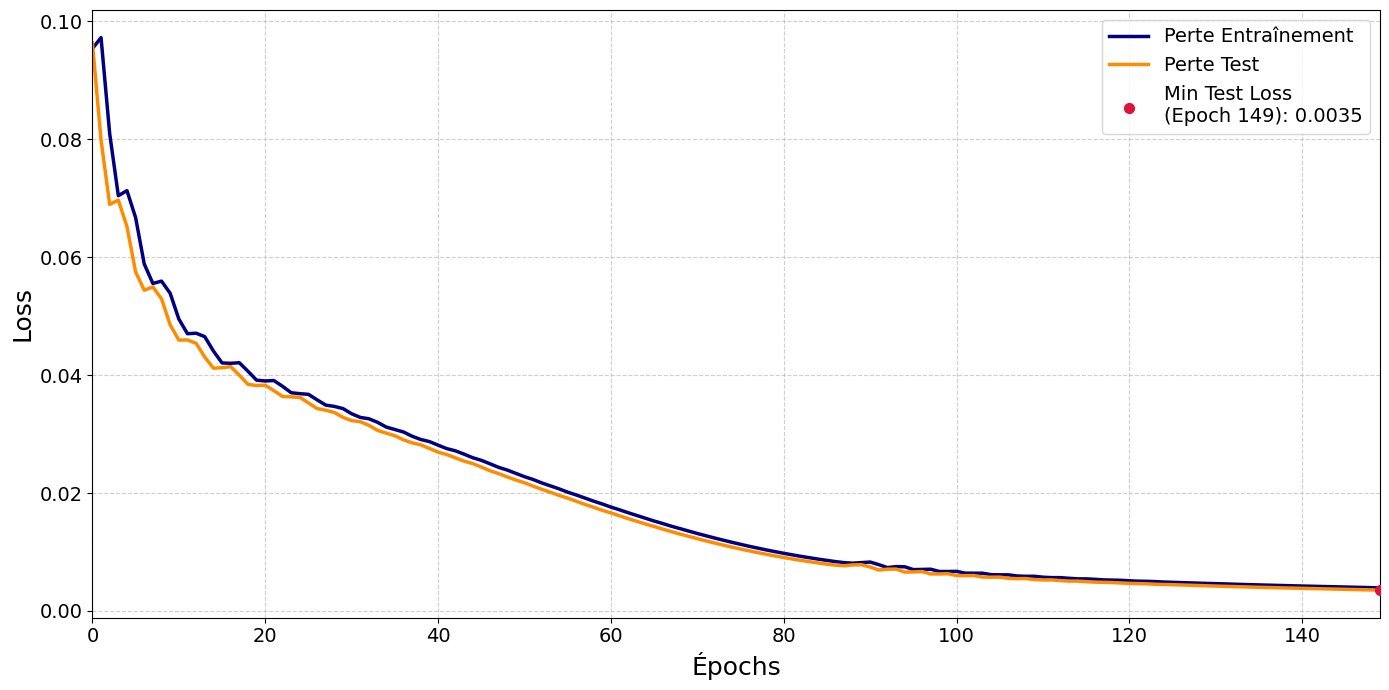

In [39]:
plot_losses(train_losses, test_losses, title="MLP Training")

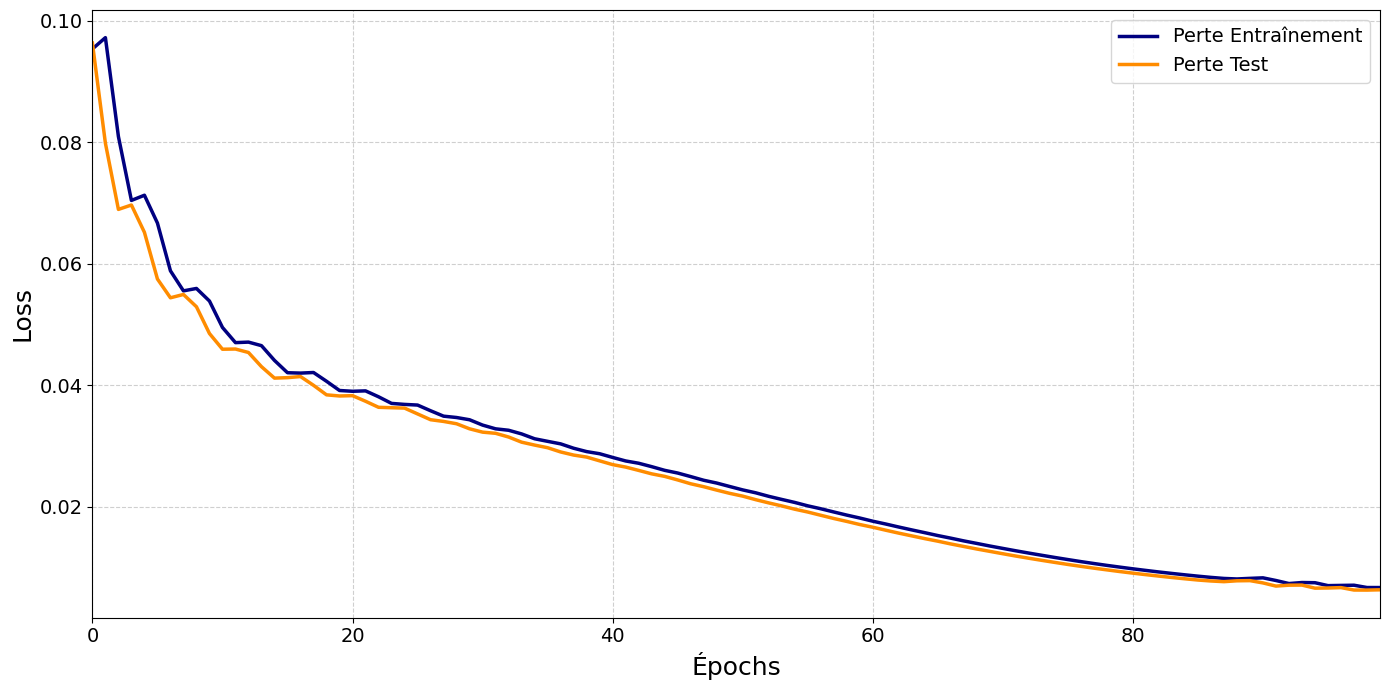

In [40]:
def plot_losses_subset(train_loss, test_loss, title, start_epoch=0, end_epoch=100):
    """
    Affiche les courbes de perte pour une plage spécifique d'époques.

    Args:
        train_loss: Liste des pertes d'entraînement.
        test_loss: Liste des pertes de test.
        title: Titre du graphique.
        start_epoch: Époque de début (inclus).
        end_epoch: Époque de fin (exclus).
    """
    plt.style.use('default')
    plt.figure(figsize=(14, 7))

    # Limiter les pertes à la plage spécifiée
    train_loss_subset = train_loss[start_epoch:end_epoch]
    test_loss_subset = test_loss[start_epoch:end_epoch]
    epochs = range(start_epoch, start_epoch + len(train_loss_subset))

    plt.plot(epochs, train_loss_subset, label='Perte Entraînement', color='navy', linewidth=2.5)
    plt.plot(epochs, test_loss_subset, label='Perte Test', color='darkorange', linewidth=2.5)

    min_test_loss = min(test_loss_subset)
    min_epoch = test_loss_subset.index(min_test_loss) + start_epoch


    plt.xlabel('Épochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(start_epoch, end_epoch - 1)
    plt.legend(fontsize=14, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_losses_subset(train_losses, test_losses, title="MLP Training (Époques 0-100)", start_epoch=0, end_epoch=100)

In [41]:
def evaluate_model(model, X_test, y_test, scaler_y):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Inverser la normalisation
    y_test_orig = inverse_transform_y(y_test, scaler_y)
    y_pred_orig = inverse_transform_y(y_pred, scaler_y)
    
    # Calcul des métriques pour chaque sortie
    n_outputs = y_test_orig.shape[1]
    metrics = {}
    for i in range(n_outputs):
        rmse = mean_squared_error(y_test_orig[:, i], y_pred_orig[:, i], squared=False)
        r2 = r2_score(y_test_orig[:, i], y_pred_orig[:, i])
        metrics[f"Output {i + 1}"] = {"RMSE": rmse, "R²": r2}
    
    # Affichage des métriques
    print("Évaluation des métriques :")
    for i, (output_name, metric) in enumerate(metrics.items()):
        if i == 0:
            print(f"Épaisseur (thickness) - RMSE: {metric['RMSE']:.4f}, R²: {metric['R²']:.4f}")
        elif i == 1:
            print(f"Fraction volumique (vfraction) - RMSE: {metric['RMSE']:.4f}, R²: {metric['R²']:.4f}")
        else:
            print(f"{output_name} - RMSE: {metric['RMSE']:.4f}, R²: {metric['R²']:.4f}")
    
    return y_test_orig, y_pred_orig, metrics

c:\Users\TimWi_x1vpvf2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\TimWi_x1vpvf2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Évaluation des métriques :
Épaisseur (thickness) - RMSE: 36.0925, R²: 0.9566
Fraction volumique (vfraction) - RMSE: 0.0174, R²: 0.9590


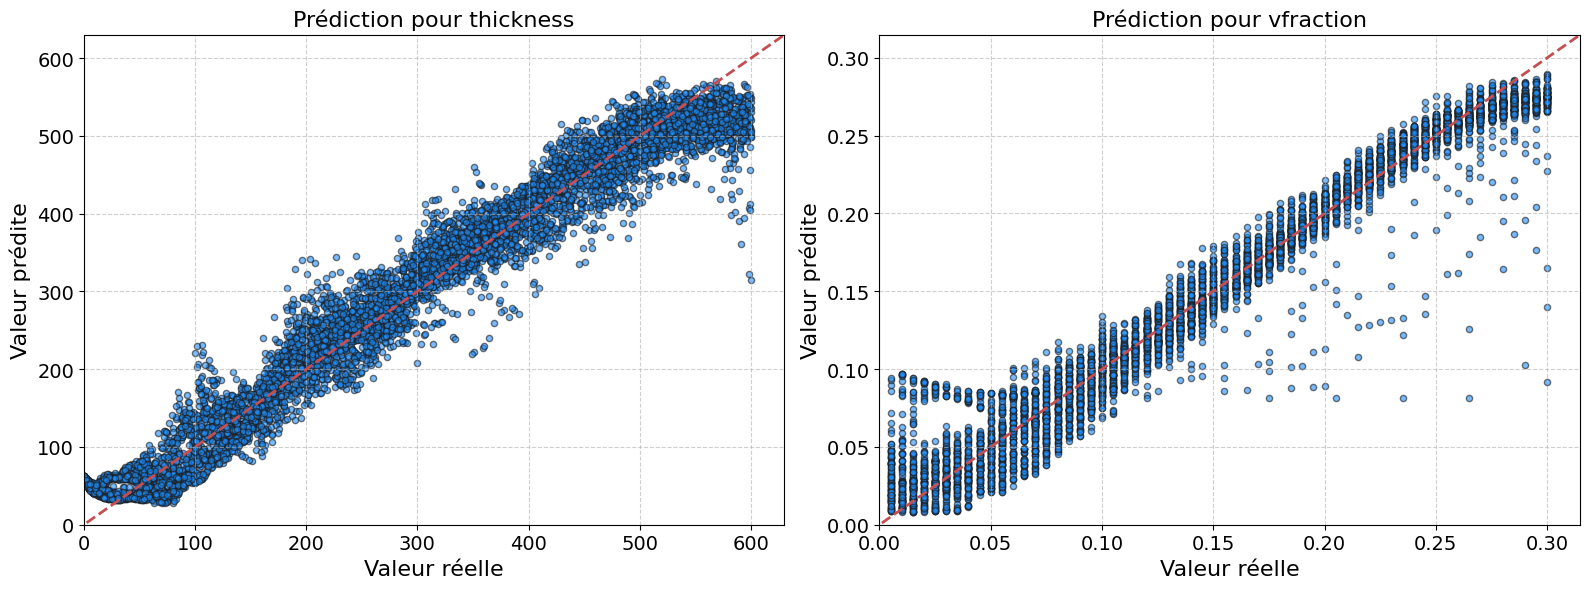

In [42]:
y_test_orig, y_pred_orig, metrics = evaluate_model(mlp_model, data['X_test'], data['y_test'], data['scaler_y'])
plot_predictions(mlp_model, data['X_test'], data['y_test'], data['scaler_y'], labels_std, title="MLP Predictions")

Nombre de NaN avant traitement: 384
Nombre de NaN après traitement: 0

Aperçu des données traitées :
       0        1        2        3        4        5        6        7    \
0  339.672  345.531   14.431    3.683   63.434   53.213   36.179   18.146   
1  357.699  338.739  325.230  355.949   11.600   22.599   62.066    1.889   
2  307.306  348.006  346.326  328.262    8.936   19.728  349.936   24.612   
3  324.729  349.087  321.340  340.429   29.907    6.250   17.073  325.753   
4  352.067  351.804    0.740  357.604  332.591  338.446  334.946  334.718   

      8        9         10       11       12       13       14       15   \
0  39.507   46.130   89.0712   14.031   11.186    2.991  341.069  339.832   
1  11.957   22.492    6.4270  356.276  331.518  326.002  341.844  334.531   
2  20.068  349.920  337.0350  324.823  317.946  304.463  326.201  307.104   
3  34.613  336.182  295.3670  322.852  246.093  326.906  312.531  235.505   
4   0.268  337.413  295.6340  318.667  249.453  254

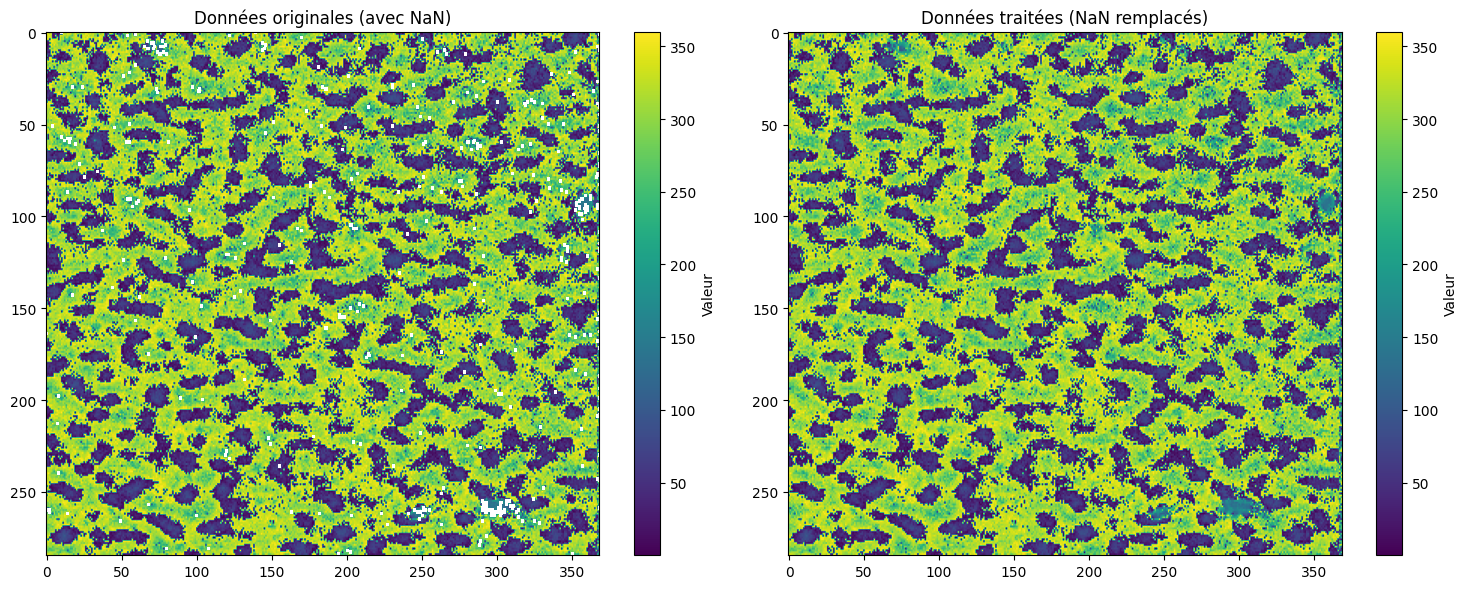

In [43]:

from scipy.ndimage import generic_filter

file_path = r"D:\Mémoire\PK221206\PK221206\MONS2-E2--ZONE1-372nm-del.map"

def replace_nan_with_local_mean(matrix):
    """Remplace les NaN par la moyenne des valeurs voisines non-NaN"""
    # Créer une copie pour éviter de modifier l'original
    result_matrix = np.copy(matrix)
    
    # Fonction pour calculer la moyenne locale
    def local_mean(window):
        window = window[~np.isnan(window)]
        return np.mean(window) if len(window) > 0 else np.nan
    
    # Trouver les positions des NaN
    nan_positions = np.where(np.isnan(matrix))
    
    # Pour chaque NaN, calculer la moyenne des 8 voisins
    for i, j in zip(*nan_positions):
        # Définir la fenêtre 3x3 autour du pixel
        i_min = max(0, i-1)
        i_max = min(matrix.shape[0], i+2)
        j_min = max(0, j-1)
        j_max = min(matrix.shape[1], j+2)
        
        window = matrix[i_min:i_max, j_min:j_max]
        mean_val = local_mean(window)
        
        # Si on a trouvé une moyenne valide, on remplace
        if not np.isnan(mean_val):
            result_matrix[i, j] = mean_val
        else:
            # Si tous les voisins sont NaN, on prend la moyenne globale
            result_matrix[i, j] = np.nanmean(matrix)
    
    return result_matrix

try:
    # Lecture des données
    raw_matrix = np.loadtxt(file_path)
    
    # Traitement des NaN
    print(f"Nombre de NaN avant traitement: {np.isnan(raw_matrix).sum()}")
    processed_matrix = replace_nan_with_local_mean(raw_matrix)
    print(f"Nombre de NaN après traitement: {np.isnan(processed_matrix).sum()}")
    
    # Conversion en DataFrame
    df_processed = pd.DataFrame(processed_matrix)
    
    # Affichage des informations
    print("\nAperçu des données traitées :")
    print(df_processed.head())
    
    print("\nStatistiques descriptives :")
    print(df_processed.describe())
    
    # Visualisation
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(raw_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Valeur')
    plt.title("Données originales (avec NaN)")
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Valeur')
    plt.title("Données traitées (NaN remplacés)")
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Erreur lors de la lecture/traitement du fichier : {e}")

In [44]:
import os
import numpy as np
from scipy.ndimage import generic_filter, zoom
from scipy.interpolate import interp1d

# 1. Lecture et nettoyage des fichiers de Zone 3
def process_zone3_files(folder_path):
    """Traite uniquement les fichiers de la Zone 3 en remplaçant les NaN et normalisant psi et delta"""
    zone3_files = [f for f in os.listdir(folder_path) if f.endswith('.map') and 'ZONE3' in f]
    
    zone3_data = {}
    
    for file_name in zone3_files:
        file_path = os.path.join(folder_path, file_name)
        
        try:
            # Lecture du fichier
            data_zone3 = np.loadtxt(file_path)
            
            # Traitement des NaN
            def replace_nan_with_neighbors(matrix):
                """Remplace les NaN par la moyenne des 8 voisins ou la moyenne globale si nécessaire."""
                result_matrix = np.copy(matrix)
                
                # Fonction pour calculer la moyenne locale
                def local_mean(window):
                    window = window[~np.isnan(window)]
                    return np.mean(window) if len(window) > 0 else np.nan
                
                # Trouver les positions des NaN
                nan_positions = np.where(np.isnan(matrix))
                
                # Pour chaque NaN, calculer la moyenne des 8 voisins
                for i, j in zip(*nan_positions):
                    i_min = max(0, i-1)
                    i_max = min(matrix.shape[0], i+2)
                    j_min = max(0, j-1)
                    j_max = min(matrix.shape[1], j+2)
                    
                    window = matrix[i_min:i_max, j_min:j_max]
                    mean_val = local_mean(window)
                    
                    # Si on a trouvé une moyenne valide, on remplace
                    if not np.isnan(mean_val):
                        result_matrix[i, j] = mean_val
                    else:
                        # Si tous les voisins sont NaN, on prend la moyenne globale
                        result_matrix[i, j] = np.nanmean(matrix)
                
                return result_matrix
            
            if np.any(np.isnan(data_zone3)):
                print(f"NaN détectés dans {file_name}: {np.isnan(data_zone3).sum()} valeurs")
                data_zone3 = replace_nan_with_neighbors(data_zone3)
            
            # Normalisation des valeurs
            if 'psi' in file_name:
                # Forcer psi à être entre -90 et 90
                data_zone3 = np.where(data_zone3 < -90, -90, data_zone3)
                data_zone3 = np.where(data_zone3 > 90, 90, data_zone3)
            elif 'del' in file_name:
                # Forcer delta à être entre -180 et 180
                data_zone3 = np.where(data_zone3 < -180, data_zone3 + 360, data_zone3)
                data_zone3 = np.where(data_zone3 > 180, data_zone3 - 360, data_zone3)
            
            # Stockage dans le dictionnaire
            zone3_data[file_name] = data_zone3
            print(f"Fichier Zone3 traité: {file_name} | Shape: {data_zone3.shape}")
            
        except Exception as e:
            print(f"Erreur avec {file_name}: {str(e)}")
            continue
    
    return zone3_data

# 2. Harmonisation des dimensions
def harmonize_dimensions(data_dict, target_shape=(1123, 739)):
    harmonized = {}
    for name, data_zone3 in data_dict.items():
        if data_zone3.shape != target_shape:
            zoom_factors = (target_shape[0]/data_zone3.shape[0], target_shape[1]/data_zone3.shape[1])
            harmonized[name] = zoom(data_zone3, zoom_factors, order=1)
            print(f"Redimensionné {name} de {data_zone3.shape} à {target_shape}")
        else:
            harmonized[name] = data_zone3
    return harmonized

# 3. Création des vecteurs par pixel
def create_pixel_vectors(zone3_data, target_wavelengths):
    shapes = {data_zone3.shape for data_zone3 in zone3_data.values()}
    if len(shapes) != 1:
        raise ValueError(f"Dimensions incohérentes après harmonisation: {shapes}")
    height, width = next(iter(shapes))

    available_wl = sorted({float(f.split('-')[-2].replace('nm','')) 
                           for f in zone3_data.keys()})
    
    pixel_map = np.zeros((height, width, 2*len(target_wavelengths)))
    
    data_cache = {}
    for wl in available_wl:
        psi_file = f"MONS2-E2--ZONE3-{int(wl)}nm-psi.map"
        delta_file = f"MONS2-E2--ZONE3-{int(wl)}nm-del.map"
        if psi_file in zone3_data and delta_file in zone3_data:
            data_cache[wl] = (zone3_data[psi_file], zone3_data[delta_file])
    
    for i in range(height):
        for j in range(width):
            psi_vals, delta_vals, valid_wl = [], [], []
            for wl in available_wl:
                if wl in data_cache:
                    psi, delta = data_cache[wl]
                    if not (np.isnan(psi[i,j]) or np.isnan(delta[i,j])):
                        psi_vals.append(psi[i,j])
                        delta_vals.append(delta[i,j])
                        valid_wl.append(wl)
            
            if len(valid_wl) >= 2:
                psi_interp = interp1d(valid_wl, psi_vals, kind='linear',
                                      bounds_error=False, fill_value='extrapolate')(target_wavelengths)
                delta_interp = interp1d(valid_wl, delta_vals, kind='linear',
                                        bounds_error=False, fill_value='extrapolate')(target_wavelengths)
                
                # Post-interpolation normalization
                psi_interp = np.clip(psi_interp, -90, 90)
                delta_interp = np.clip(delta_interp, -180, 180)
            else:
                psi_interp = np.zeros(len(target_wavelengths))
                delta_interp = np.zeros(len(target_wavelengths))
            
            pixel_map[i,j] = np.column_stack([psi_interp, delta_interp]).flatten()
    
    return pixel_map

# ------------------------
# Utilisation du script
# ------------------------

# Longueurs d'onde cibles
target_wl = np.array([
    361.5, 372.8, 381.3, 391.0, 400.8, 411.2, 425.1, 430.6, 439.7,
    450.0, 461.0, 468.9, 481.0, 492.9, 501.0, 509.6, 520.8, 533.0,
    545.5, 562.6, 572.3, 590.0, 601.5, 609.8, 633.2, 641.0, 660.4,
    675.1, 688.5, 712.2, 722.2, 742.4, 762.8, 770.5, 791.8, 812.8,
    827.7, 852.6, 871.5, 881.9, 904.4, 920.3, 952.3, 971.1, 1000.3
])

folder_path = r"D:\Mémoire\PK221206\PK221206"

# Étape 1 : lecture et traitement des fichiers Zone 3
zone3_data = process_zone3_files(folder_path)

# Étape 2 : harmonisation des tailles
print("\nHarmonisation des dimensions...")
zone3_data_harmonized = harmonize_dimensions(zone3_data)

# Étape 3 : génération des vecteurs par pixel
print("\nCréation des vecteurs pixels...")
pixel_vectors = create_pixel_vectors(zone3_data_harmonized, target_wl)

# Vérification
print("\nRésultats:")
print(f"- Dimensions de la map: {pixel_vectors.shape}")
print(f"- Nombre de longueurs d'onde: {len(target_wl)}")
print(f"- Nombre de features par pixel: {pixel_vectors.shape[2]} (attendu: {2*len(target_wl)})")

# Exemple pour un pixel
sample_pixel = pixel_vectors[50,50]
print("\nExemple de vecteur pour un pixel:")
print(f"Psi values (entre -90 et 90): {sample_pixel[::2]}")
print(f"Delta values (entre -180 et 180): {sample_pixel[1::2]}")

NaN détectés dans MONS2-E2--ZONE3-372nm-del.map: 1295 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-372nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-372nm-psi.map: 1157 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-372nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-381nm-del.map: 1494 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-381nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-381nm-psi.map: 1396 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-381nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-391nm-del.map: 109 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-391nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-391nm-psi.map: 44 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-391nm-psi.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-400nm-del.map: 1042 valeurs
Fichier Zone3 traité: MONS2-E2--ZONE3-400nm-del.map | Shape: (1123, 739)
NaN détectés dans MONS2-E2--ZONE3-400nm-psi.map: 1384 vale

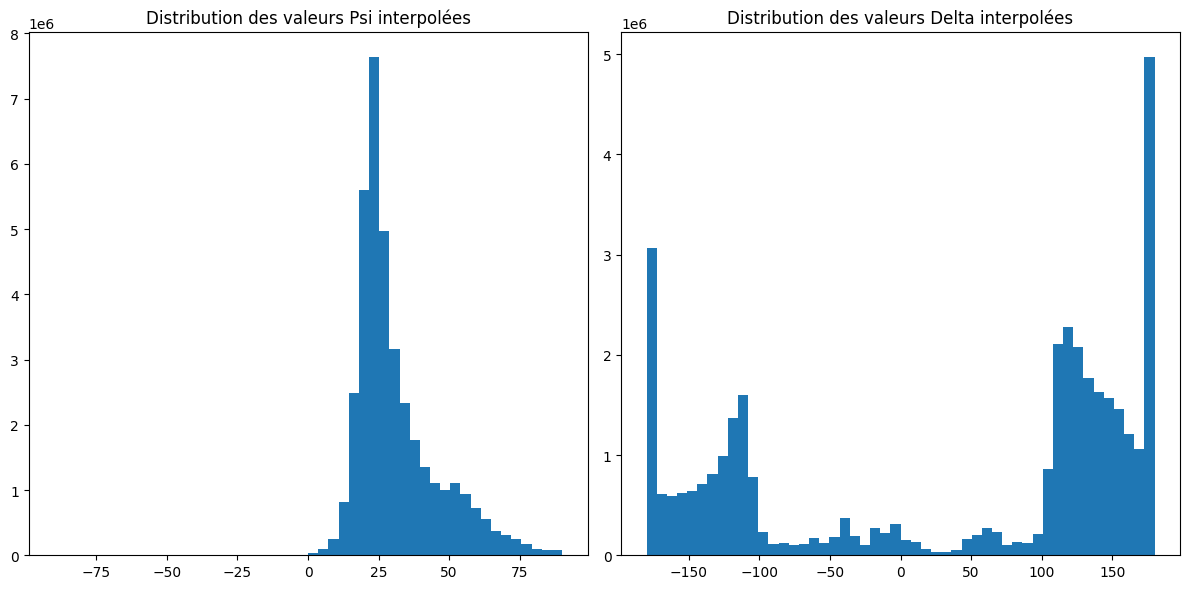

In [45]:
import matplotlib.pyplot as plt

# Visualisation des distributions
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist(pixel_vectors[:,:,::2].flatten(), bins=50)
plt.title('Distribution des valeurs Psi interpolées')

plt.subplot(122)
plt.hist(pixel_vectors[:,:,1::2].flatten(), bins=50)
plt.title('Distribution des valeurs Delta interpolées')

plt.tight_layout()
plt.show()

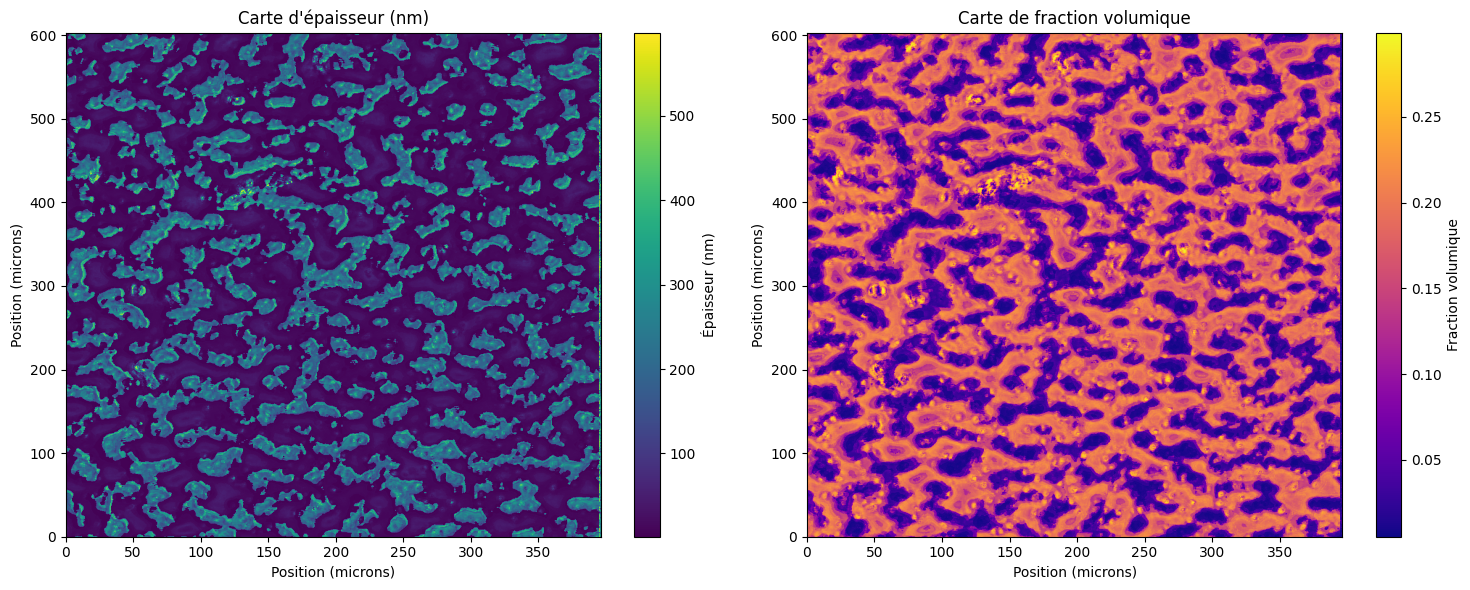


Statistiques avec unités physiques:
- Résolution spatiale: 0.537212 microns/pixel
- Épaisseur: 90.68 ± 119.16 nm
- Fraction volumique: 0.1270 ± 0.0716
Taille physique de la carte: 396.5 microns


In [46]:
def generate_prediction_maps(pixel_vectors, mlp_model, data):
    """
    Génère des cartes de prédiction avec axes en microns.
    
    Args:
        pixel_vectors: Array numpy des vecteurs pixels (shape: [height, width, 2*n_wavelengths])
        mlp_model: Modèle PyTorch entraîné
        data: Dictionnaire contenant les scalers
    
    Returns:
        Dictionnaire contenant les cartes et statistiques avec unités physiques
    """
    # Paramètres métriques (d'après votre en-tête)
    xscale = 0.537212  # microns/px
    yscale = 0.537212  # microns/px
    xyunit = 'microns'
    
    # 1. Préparation des données
    original_shape = pixel_vectors.shape[:2]
    features = pixel_vectors.reshape(-1, pixel_vectors.shape[2])
    
    # 2-4. Prétraitement et prédiction (inchangé)
    features_normalized = data['scaler_X'].transform(features)
    
    mlp_model.eval()
    with torch.no_grad():
        predictions_normalized = mlp_model(torch.FloatTensor(features_normalized)).numpy()
    
    predictions = data['scaler_y'].inverse_transform(predictions_normalized)
    
    # 5. Reconstruction avec calcul des positions physiques
    thickness_map = predictions[:, 0].reshape(original_shape)
    vfraction_map = predictions[:, 1].reshape(original_shape)
    
    # Création des axes en microns
    x = np.arange(thickness_map.shape[1]) * xscale
    y = np.arange(thickness_map.shape[0]) * yscale
    extent = [x[0], x[-1], y[0], y[-1]]
    
    # 6. Statistiques (inchangé)
    stats = {
        'thickness_mean': np.nanmean(thickness_map),
        'thickness_std': np.nanstd(thickness_map),
        'vfraction_mean': np.nanmean(vfraction_map),
        'vfraction_std': np.nanstd(vfraction_map),
        'physical_units': {
            'xscale': xscale,
            'yscale': yscale,
            'unit': xyunit
        }
    }

    # 7. Visualisation avec axes métriques
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    im1 = plt.imshow(thickness_map, cmap='viridis', extent=extent, aspect='auto')
    plt.colorbar(im1, label='Épaisseur (nm)')
    plt.xlabel(f'Position ({xyunit})')
    plt.ylabel(f'Position ({xyunit})')
    plt.title('Carte d\'épaisseur (nm)')
    
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(vfraction_map, cmap='plasma', extent=extent, aspect='auto')
    plt.colorbar(im2, label='Fraction volumique')
    plt.xlabel(f'Position ({xyunit})')
    plt.ylabel(f'Position ({xyunit})')
    plt.title('Carte de fraction volumique')
    
    plt.tight_layout()
    plt.show()

    # 8. Affichage amélioré des stats
    print("\nStatistiques avec unités physiques:")
    print(f"- Résolution spatiale: {xscale} {xyunit}/pixel")
    print(f"- Épaisseur: {stats['thickness_mean']:.2f} ± {stats['thickness_std']:.2f} nm")
    print(f"- Fraction volumique: {stats['vfraction_mean']:.4f} ± {stats['vfraction_std']:.4f}")
    
    return {
        'thickness_map': thickness_map,
        'vfraction_map': vfraction_map,
        'stats': stats,
        'physical_coords': {
            'x_axis': x,
            'y_axis': y
        }
    }

results = generate_prediction_maps(pixel_vectors, mlp_model, data)
print(f"Taille physique de la carte: {results['physical_coords']['x_axis'][-1]:.1f} microns")

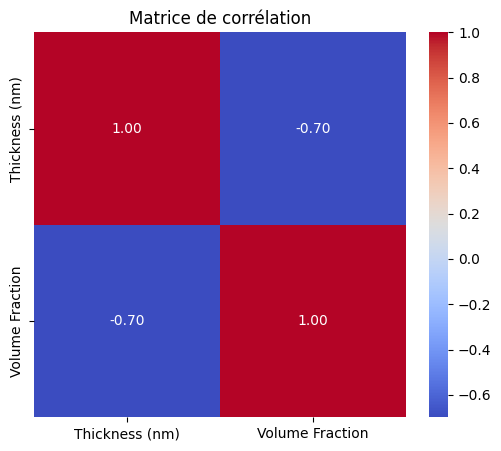

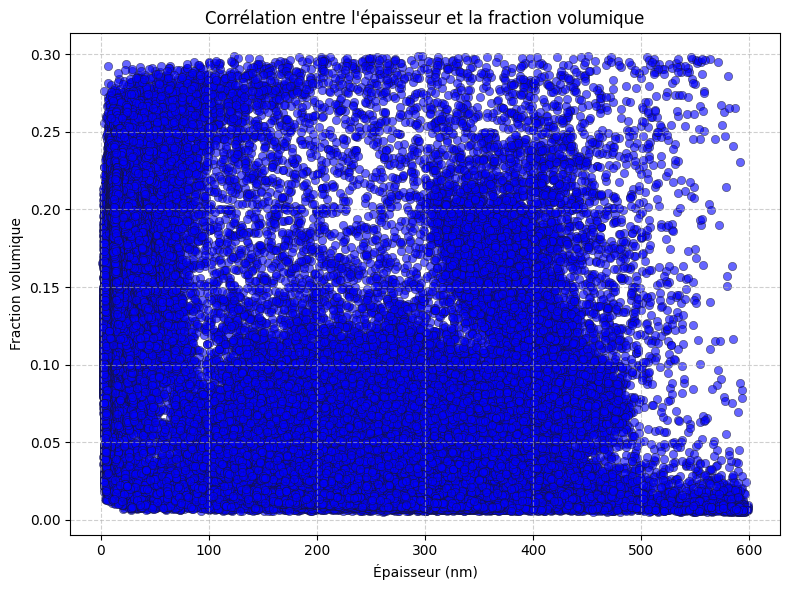

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_thickness_vfraction_correlation(thickness_map, vfraction_map):
    """
    Visualise la corrélation entre l'épaisseur et la fraction volumique.

    Args:
        thickness_map: Carte des épaisseurs (numpy array 2D)
        vfraction_map: Carte des fractions volumiques (numpy array 2D)
    """
    # Aplatir les cartes pour obtenir des listes de valeurs
    thickness_values = thickness_map.flatten()
    vfraction_values = vfraction_map.flatten()

    # Supprimer les NaN pour éviter les problèmes dans les calculs
    valid_indices = ~np.isnan(thickness_values) & ~np.isnan(vfraction_values)
    thickness_values = thickness_values[valid_indices]
    vfraction_values = vfraction_values[valid_indices]

    # Créer un DataFrame pour faciliter l'analyse
    data = pd.DataFrame({
        'Thickness (nm)': thickness_values,
        'Volume Fraction': vfraction_values
    })

    # Calculer la corrélation
    correlation = data.corr()

    # Afficher la matrice de corrélation
    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Matrice de corrélation")
    plt.show()

    # Graphique de dispersion
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Thickness (nm)', y='Volume Fraction', data=data, alpha=0.6, color='blue', edgecolor='k')
    plt.title("Corrélation entre l'épaisseur et la fraction volumique")
    plt.xlabel("Épaisseur (nm)")
    plt.ylabel("Fraction volumique")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Appeler la fonction avec les cartes générées
plot_thickness_vfraction_correlation(results['thickness_map'], results['vfraction_map'])